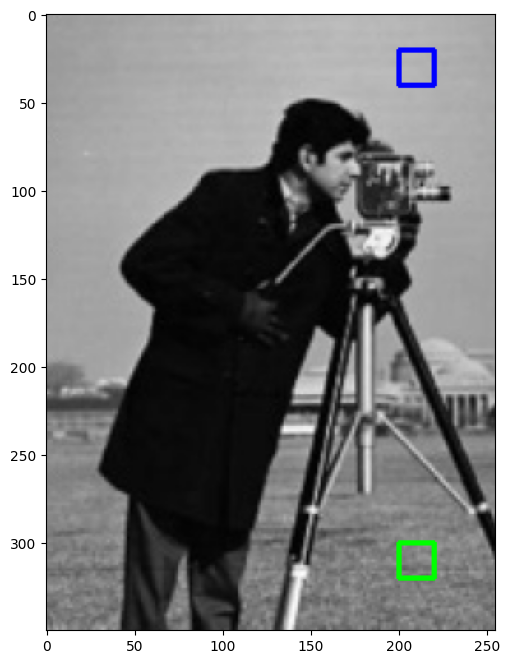

In [1]:
# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
import matplotlib.pyplot as plt
import cv2
import numpy as np
img = cv2.imread('img/photographer.png')

window = cv2.rectangle(img.copy(), (200,20), (220,40), (0, 0, 255), 2)
window = cv2.rectangle(window, (200,300), (220,320), (0, 255, 0), 2)
plt.figure(figsize= (6,8))
plt.imshow(window, cmap='gray')
plt.show()

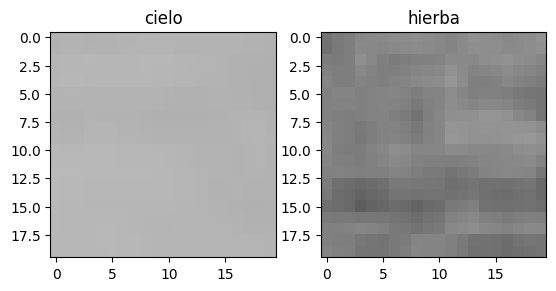

In [2]:
# Seleccionamos una región del cielo y una de la hierba
cielo = img[20:40,200:220]
hierba = img[300:320, 200:220]

fig, ax = plt.subplots(1,2)
ax[0].imshow(cielo, cmap='gray')
ax[0].set_title('cielo')
ax[1].imshow(hierba, cmap='gray')
ax[1].set_title('hierba')
plt.show()

### MATRIZ DE COOCURRENCIA

In [3]:
# MATRIZ DE COOCURRENCIA (Gray-Level Cooccurence Matrix - GLCM)
from tabulate import tabulate
from skimage.feature import graycomatrix, graycoprops

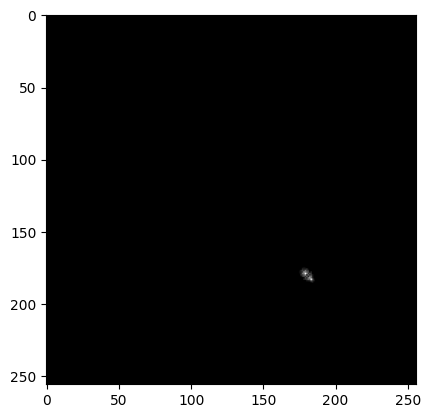

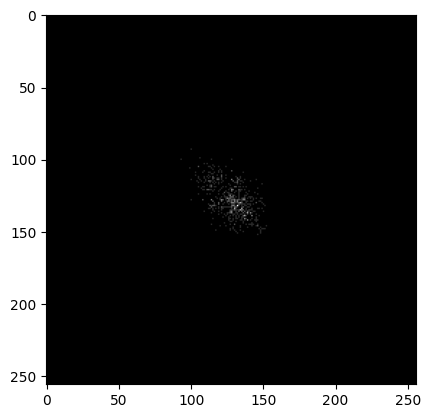

                  cielo        hierba
------------  ---------  ------------
contraste     4.14667    106.503
disimilitud   1.59333      7.97667
homogeneidad  0.440151     0.127143
ASM           0.0217444    0.00271111
Energía       0.14746      0.0520683
Correlación   0.598256     0.536413


In [4]:

headers = ['','cielo', 'hierba']
CN, DIS, H, ASM, E, COR = ['contraste'], ['disimilitud'], ['homogeneidad'], ['ASM'], ['Energía'], ['Correlación']

patches = []
patches.append(cielo)
patches.append(hierba)

for i in range(len(patches)):
    image = cv2.cvtColor(patches[i], cv2.COLOR_BGR2GRAY)             # pasar a escala de grises

    '''
    a la funcion greycomatrix le paso:
    1- la imagen
    2- las distancias para la mdc 
    3- el angulo al que quremeos extraer la mdc
    4- los niveles de la imagen, como minimo debe tener el valor máximo de la intensidad de la imagen
    5,6, etc: parametros para normalizar y ajsutar la imagen 
    '''
    GLCM = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    plt.imshow(GLCM[:,:,0,0], cmap= 'gray')
    plt.show()

    # con estos comandos de la funcion graycoprops extraemos las caracteristicas que queremos
    CN.append(graycoprops(GLCM, 'contrast')[0,0])
    DIS.append(graycoprops(GLCM, 'dissimilarity')[0,0])
    H.append(graycoprops(GLCM, 'homogeneity')[0,0])
    ASM.append(graycoprops(GLCM, 'ASM')[0,0])
    E.append(graycoprops(GLCM, 'energy')[0,0])
    COR.append(graycoprops(GLCM, 'correlation')[0,0])

my_data = [tuple(CN), tuple(DIS), tuple(H), tuple(ASM), tuple(E), tuple(COR)]

print(tabulate(my_data, headers=headers))

# Scale-Invariant Feature Transform

El algoritmo SIFT se utiliza en aplicaciones que involucran un escalado de la imagen. Sirve para la detección de esquinas, bordes o texturas siendo estable frente a perturbaciones y transformaciones que pueda sufrir la imagen. Es invariante a posición, escala, rotación, iluminación y contraste. El algoritmo consta de las siguientes fases:


In [5]:
img = cv2.imread('img/photographer.png')

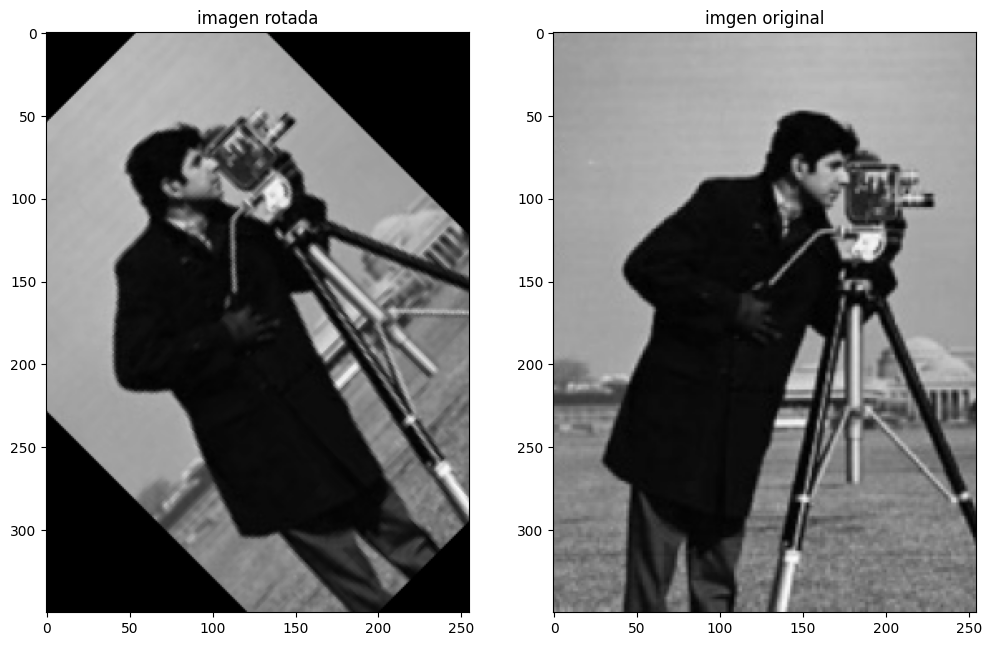

In [6]:
# SIFT algorithm
# imagen rotada
rows, cols, _ = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2), angle= 45, scale=1)
img_rot = cv2.warpAffine(img, M, (cols, rows))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,10)
ax[0].imshow(img_rot, cmap= 'gray')
ax[0].set_title('imagen rotada')
ax[1].imshow(img, cmap= 'gray')
ax[1].set_title('imgen original')
plt.show()

(469, 128)


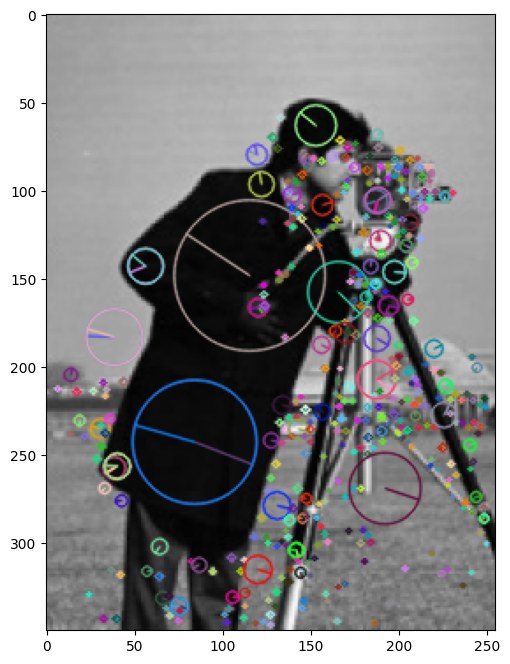

In [7]:
# PARA LA IMAGEN ORIGINAL
# Definición del algoritmo
sift = cv2.SIFT_create(nfeatures= 0, nOctaveLayers= 3)

# Identificamos los puntos de interés
kp = sift.detect(img, None)

# Extraemos el descriptor para obtener el fingreprint
_, des = sift.compute(img, kp)
print(np.shape(des))
# print(des) # Matriz donde las filas son los keypoints y las columnas las características de dichos puntos clave

# Visualizamos los puntos de interés
img_int=cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize= (6,8))
plt.imshow(img_int)
plt.show()

(469, 128)


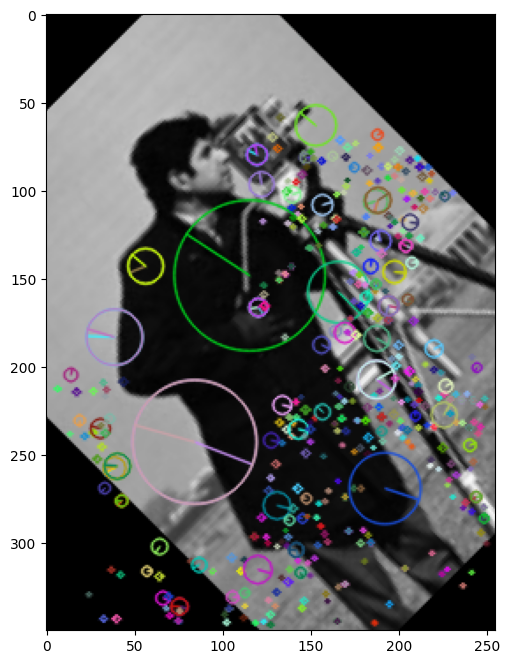

In [8]:
# PARA LA IMAGEN ORIGINAL
# no hace falta volver a definir en algoritmo

# Identificamos los puntos de interés
kp_rot = sift.detect(img_rot, None)

# Extraemos el descriptor para obtener el fingreprint
_, des_rot = sift.compute(img_rot, kp)
print(np.shape(des_rot))
# print(des) # Matriz donde las filas son los keypoints y las columnas las características de dichos puntos clave

# Visualizamos los puntos de interés
img_int_rot=cv2.drawKeypoints(img_rot, kp, img_rot, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize= (6,8))
plt.imshow(img_int_rot)
plt.show()

(81,)


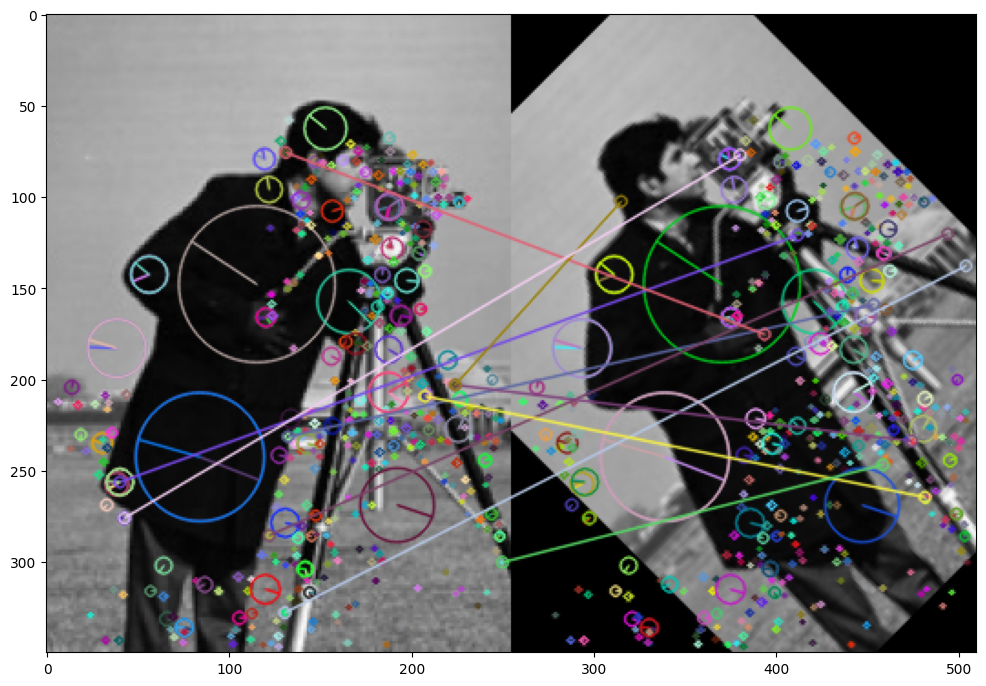

In [9]:
# feature matching

from skimage import io

bf = cv2.BFMatcher.create(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des, des_rot)
matches = sorted(matches, key = lambda x: x.distance)

print(np.shape(matches))

img_match = cv2.drawMatches(img, kp, img_rot, kp_rot, matches[:10], img_rot, flags= 10)
plt.figure(figsize= (12,15))
plt.imshow(img_match, cmap= 'gray')
plt.show()

### Histogram of Oriented Gradients 

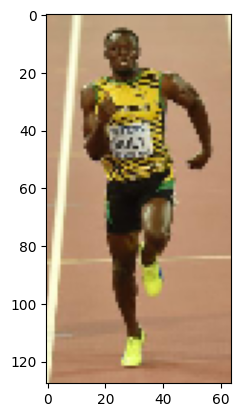

In [10]:
# HISTOGRAM OF ORIENTED GRADIENTS

# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
from skimage import io
img = io.imread('img/pedestrian.jpg')
img = np.float32(img/255)
crop = img[75:550,475:700]
crop = cv2.resize(crop, (64, 128))

plt.imshow(crop, cmap='gray')
plt.show()

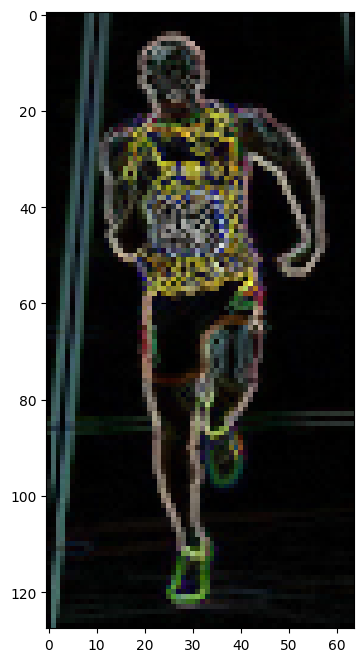

In [14]:
# Calculamos el gradiente con el kernel de Sobel
crop = np.float32(crop)
gx = cv2.Sobel(crop, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(crop, cv2.CV_32F, 0, 1, ksize=1)

# Calculamos la magnitud y la dirección del gradiente
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

# Visualizamos la imagen obtenida en la magnitud del gradiente
mag = mag/np.max(mag)
plt.figure(figsize= (6,8))
plt.imshow(mag, cmap='gray')
plt.show()

In [12]:
# Cálculo del desriptor: Histogram of Oriented Gradients
from skimage.feature import hog
H = hog(crop, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", channel_axis=2)
np.shape(H)

(3780,)

### Local Binary Patterns

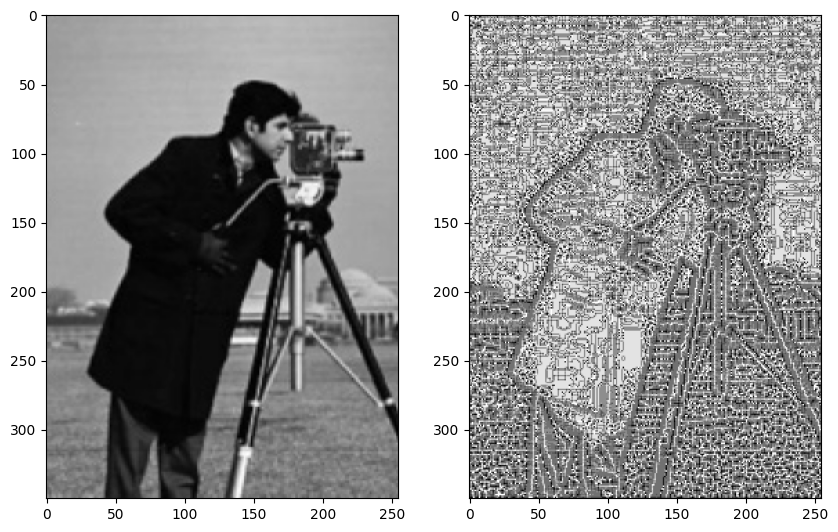

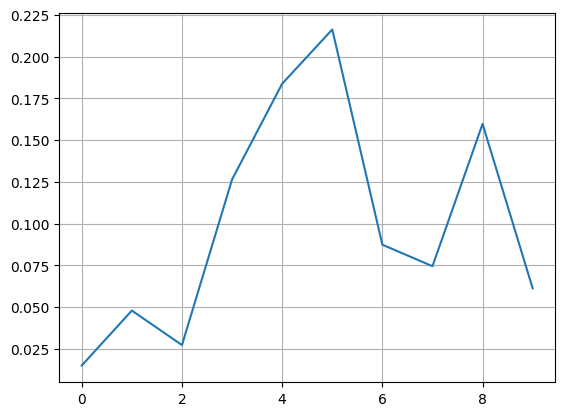

In [13]:
# LOCAL BINARY PATTERNS (LBP)
from skimage.feature import local_binary_pattern
img = cv2.imread('img/photographer.png')

# Definimos los parámetros iniciales
R = 1 # Radio
P = 8*R # Número de píxeles vecinos
epsilon = 1e-7 # Para normalizar el histograma

# Extraemos la imagen LBP
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lbp_image = local_binary_pattern(img_gray, P, R, method='uniform')
a,b = np.unique(lbp_image, return_counts=True)

# Calculamos el histograma
lbp_image = np.uint8(lbp_image)
hist = cv2.calcHist([lbp_image.ravel()], [0], None, [P+2], [0, P+2])

# Normalizamos el histograma
hist = hist.astype("float")
hist /= (hist.sum() + epsilon)

# Los P+2=10 bins del histograma serán los 10 atributos que nos permitirán caracterizar una imagen

# Visualizamos la imagen LBP
figs, ax = plt.subplots(1,2)
figs.set_size_inches(10,16)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(lbp_image, cmap='gray')
plt.show()

# Visualizamos el histograma
plt.plot(hist)
plt.grid(True)
plt.show()